## 課題3
* 次のモデル2について、データ分析を実践してみよう。
* ヒント： 使用する説明変数を置き換えればいいだけ。

* モデル2: 婚姻年齢の中央値による予測

In [1]:
!pip install arviz
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import jax
import jax.numpy as jnp
from jax import random
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

import arviz as az

%config InlineBackend.figure_format = 'retina'

plt.style.use("bmh")
rng_key = random.PRNGKey(0)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

## モデル2: 婚姻年齢の中央値による予測

### データセット

In [3]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*ar

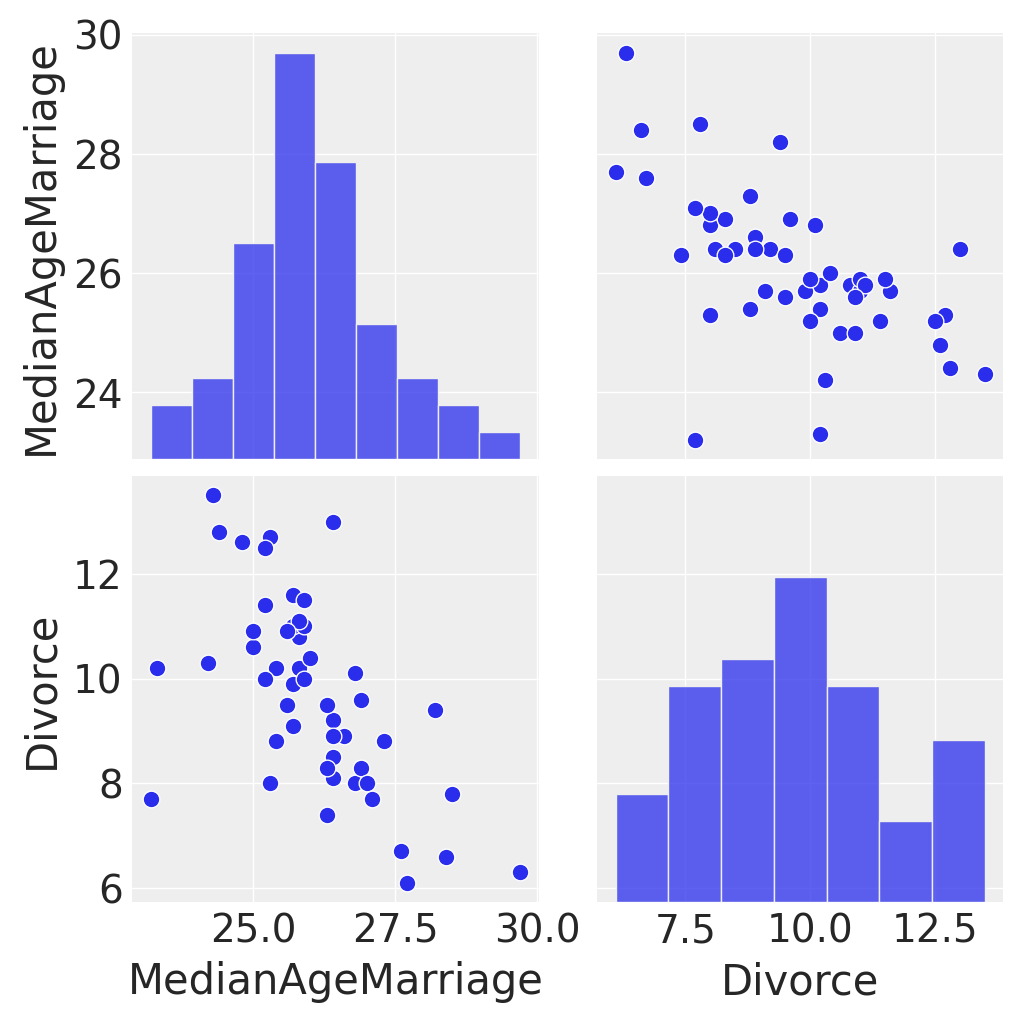

In [4]:
vars = [
    "MedianAgeMarriage",
    "Divorce",
]
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette="husl");

### データの標準化

In [5]:
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,AgeScaled,DivorceScaled
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.927058


### モデルの構成
* 今回使うモデルの構成を式で書くと、以下のようになる。
$$\begin{align}
a & \sim N(0, 0.2^2) \\
b_M & \sim N(0, 0.5^2) \\
b_A & \sim N(0, 0.5^2) \\
\sigma & \sim \mbox{Exp}(1) \\
\mu & \equiv a + b_M x_M + b_A x_A \\
y & \sim N(\mu, \sigma^2)
\end{align}$$

In [6]:
def model(marriage=None, age=None, divorce=None):
  a = numpyro.sample("a", dist.Normal(0.0, 0.2))
  M, A = 0.0, 0.0
  if marriage is not None:
    bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
    M = bM * marriage
  if age is not None:
    bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
    A = bA * age
  sigma = numpyro.sample("sigma", dist.Exponential(1.0))
  mu = a + M + A
  numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

### MCMCの実行
* 説明変数:婚姻年齢の中央値
* 目的変数:離婚率

In [7]:
rng_key, rng_key_ = random.split(rng_key)

In [8]:
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=2)

mcmc.run(
    rng_key_, age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values
)

<ipython-input-8-ed5be160983b>:3: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=2)
sample: 100%|██████████| 3000/3000 [00:04<00:00, 664.83it/s, 3 steps of size 8.44e-01. acc. prob=0.89]


In [9]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.10     -0.00     -0.17      0.17   3973.17      1.00
        bA     -0.57      0.11     -0.57     -0.76     -0.38   4256.65      1.00
     sigma      0.82      0.09      0.81      0.69      0.96   3710.73      1.00

Number of divergences: 0


In [10]:
samples_1 = mcmc.get_samples()
samples_1['a'].shape

(4000,)

### サンプルの可視化

In [11]:
idata_1 = az.from_numpyro(mcmc)
idata_1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [12]:
df_idata_1 = idata_1.posterior.to_dataframe()
df_idata_1.head()

a        bA     sigma
chain draw                              
0     0    -0.094126 -0.498491  0.791407
      1    -0.050263 -0.333355  0.770328
      2    -0.027751 -0.806244  0.868180
      3    -0.093404 -0.621469  0.724973
      4     0.030535 -0.655597  0.842355

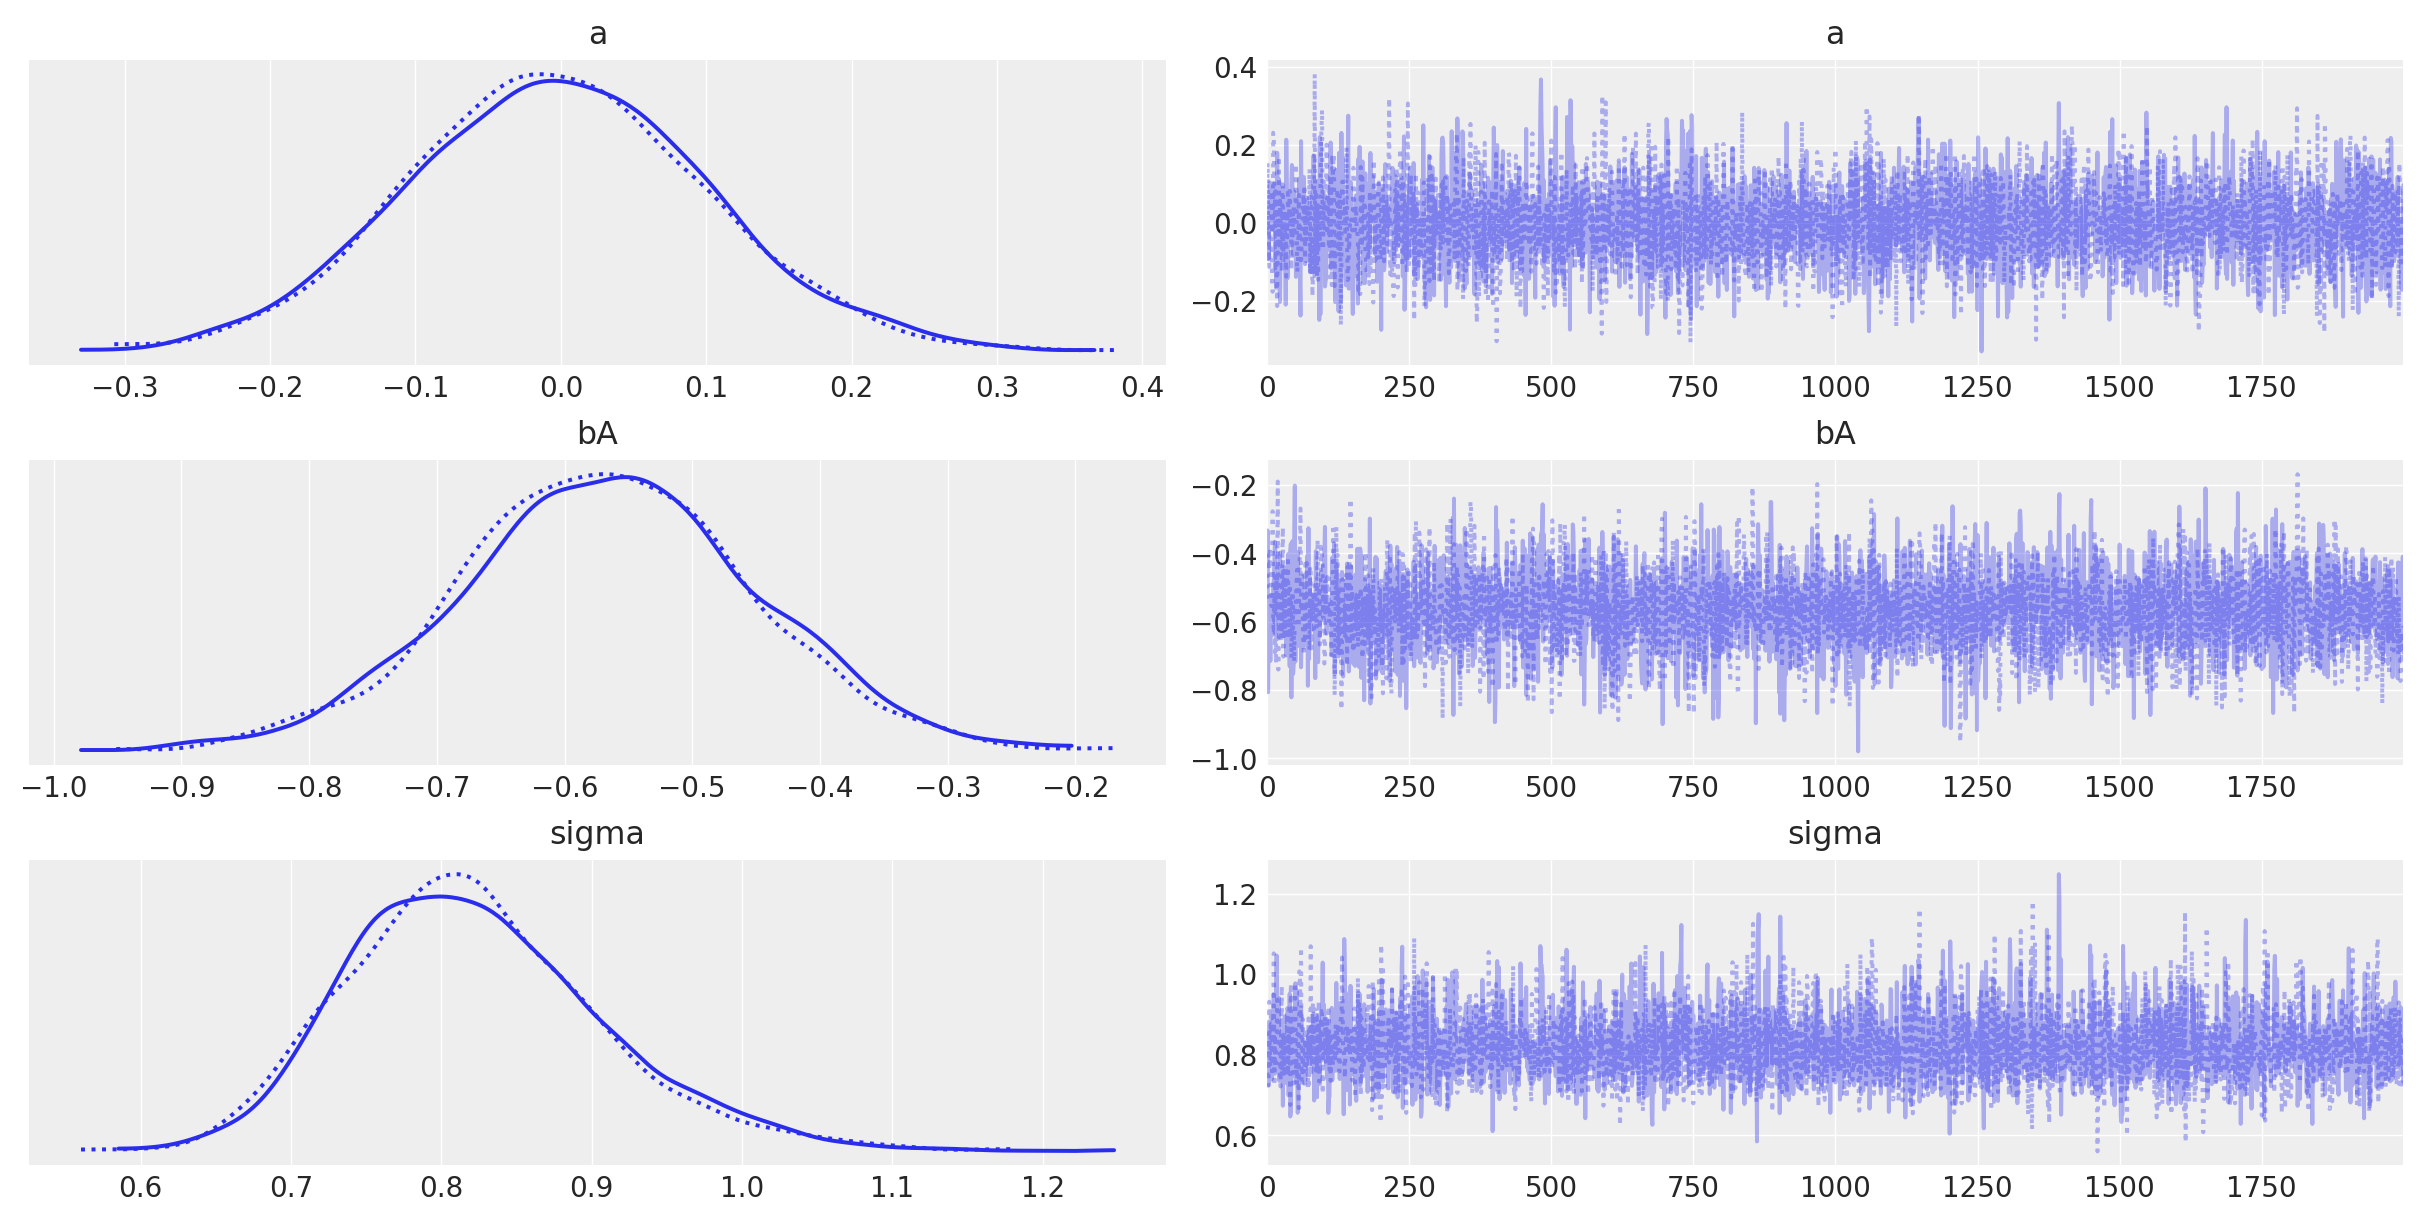

In [13]:
az.plot_trace(idata_1);

### 目的変数の期待値の信用区間

* 説明変数の値が$x_{A,i}$のときの目的変数の（誤差が従う分布について求められる）期待値
$$\begin{align}\mu_i \equiv E_{\sigma}[y | x_{A,i}] = E_{\sigma}[a + b_A x_{A,i} + \sigma] = a + b_A x_{A,i}\end{align}$$

In [14]:
posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1)
    + jnp.expand_dims(samples_1["bA"], -1) * dset.AgeScaled.values
)
posterior_mu.shape

(4000, 50)

この結果を使って、標準化された婚姻年齢の中央値の様々な値に対して、対応する離婚率の期待値の、平均とHPDIを求める。

In [15]:
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)

* 90%信用区間は、90% highest posterior density interval (HPDI)として求めている。
 * https://num.pyro.ai/en/stable/diagnostics.html#hpdi
 * 切片や係数のHPDIを求めて、回帰式に当てはめればよい。

In [16]:
def plot_regression(x, y_mean, y_hpdi):
  # Sort values for plotting by x axis
  idx = jnp.argsort(x)
  age = x[idx]
  mean = y_mean[idx]
  hpdi = y_hpdi[:, idx]
  divorce = dset.DivorceScaled.values[idx]

  # Plot
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
  ax.plot(age, mean)
  ax.plot(age, divorce, "o")
  ax.fill_between(age, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
  return ax

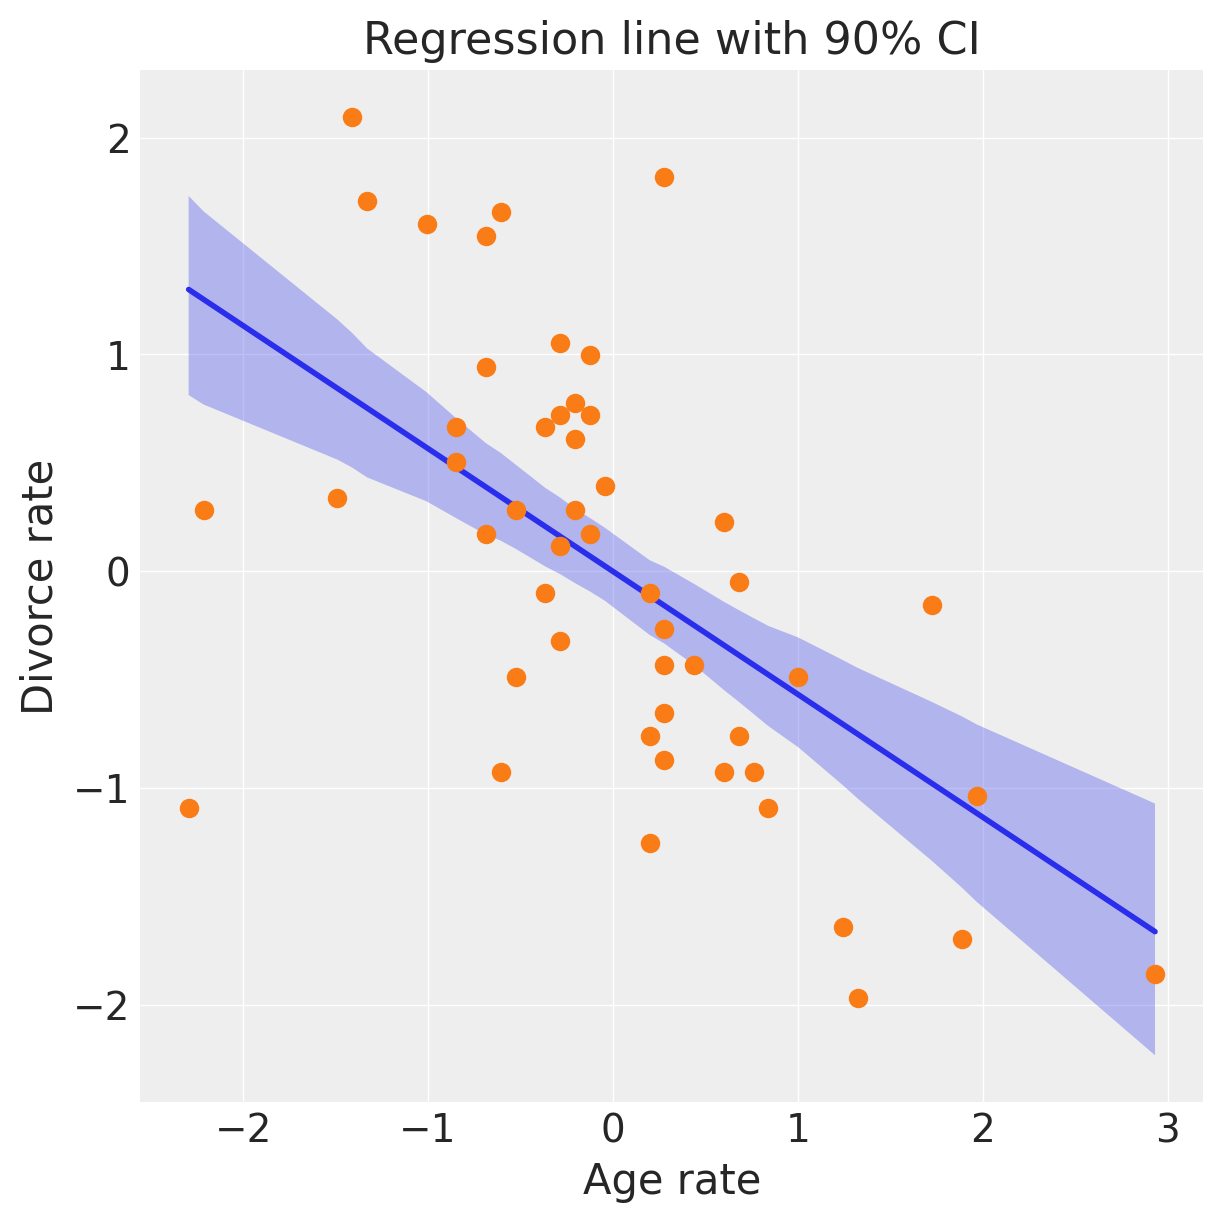

In [17]:
ax = plot_regression(dset.AgeScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Age rate", ylabel="Divorce rate", title="Regression line with 90% CI",
);

### 目的変数の予測値の信用区間

In [18]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1) # ここで予測分布を作っている
predictions_1 = predictive(rng_key_, age=dset.AgeScaled.values)["obs"]

In [19]:
mean_pred = jnp.mean(predictions_1, axis=0)

df = dset.filter(["Location"])
df["Mean Predictions"] = mean_pred
df.head()

,Location,Mean Predictions
0,Alabama,0.341785
1,Alaska,0.382510
2,Arizona,0.104133
3,Arkansas,0.792124
4,California,-0.332852


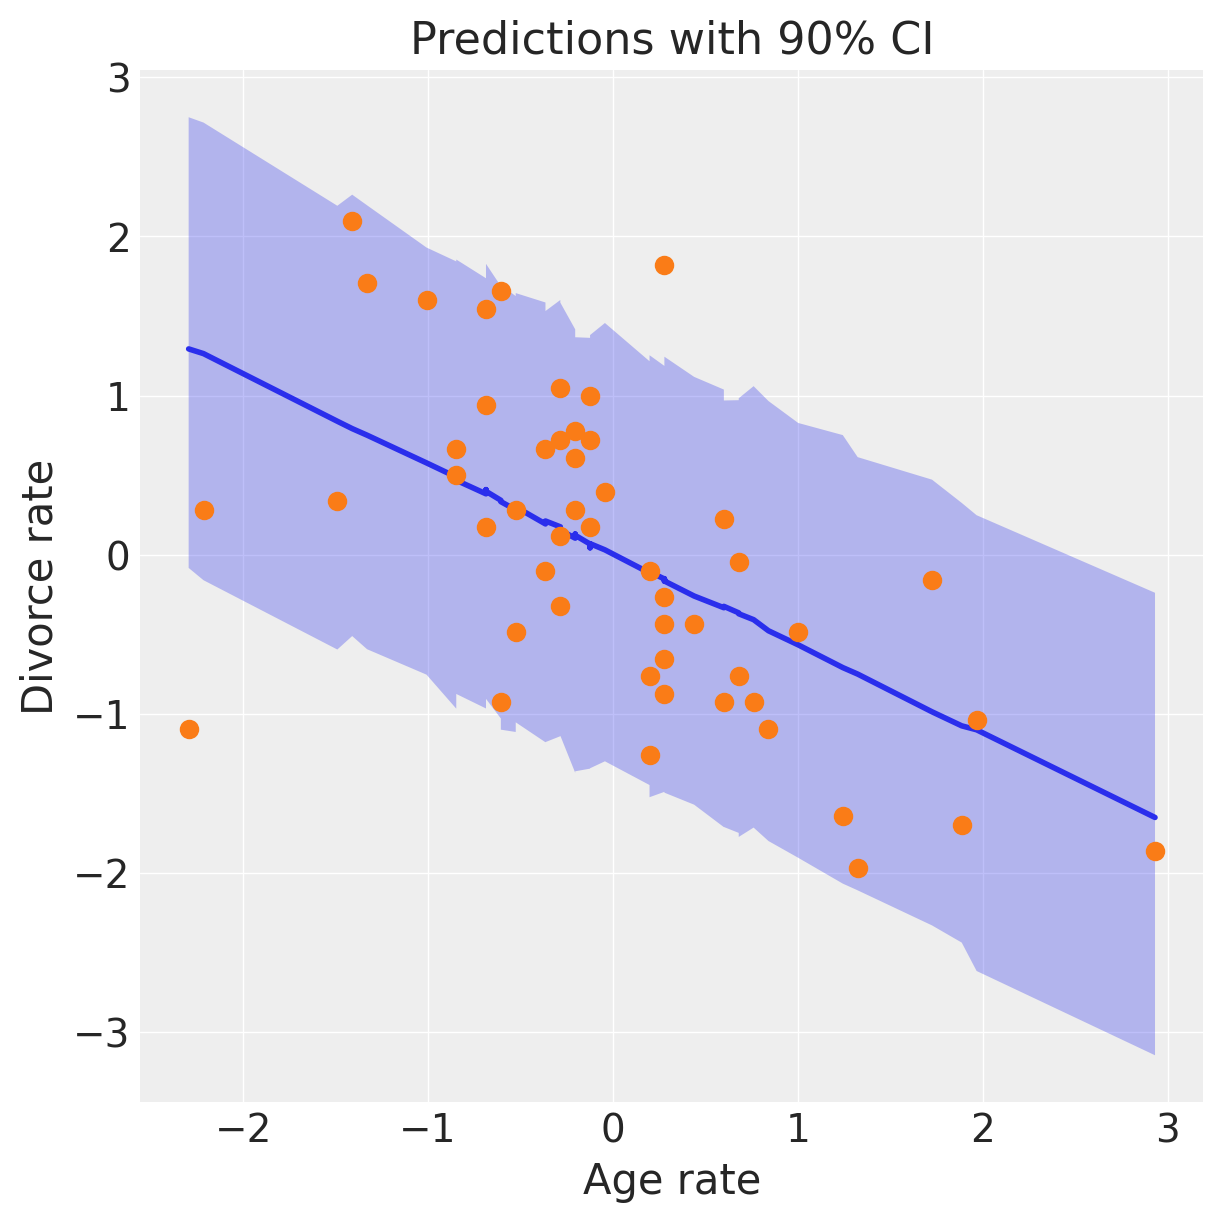

In [20]:
hpdi_pred = hpdi(predictions_1, 0.9)

ax = plot_regression(dset.AgeScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Age rate", ylabel="Divorce rate", title="Predictions with 90% CI");